In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# NVTabular demo on Rossmann data

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.

### Learning objectives

This notebook demonstrates the steps for carrying out data preprocessing, transformation and loading with NVTabular on the Kaggle Rossmann [dataset](https://www.kaggle.com/c/rossmann-store-sales/overview).  Rossmann operates over 3,000 drug stores in 7 European countries. Historical sales data for 1,115 Rossmann stores are provided. The task is to forecast the "Sales" column for the test set. 

The following example will illustrate how to use NVTabular to preprocess and load tabular data for training neural networks in both PyTorch and TensorFlow. We'll use a [dataset built by FastAI](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb) for solving the [Kaggle Rossmann Store Sales competition](https://www.kaggle.com/c/rossmann-store-sales). Some pandas preprocessing is required to build the appropriate feature set, so make sure to run [rossmann-store-sales-preproc.ipynb](./rossmann-store-sales-preproc.ipynb) first before going through this notebook.

In [2]:
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import random
random.seed(42)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
from time import time
import re
import glob
import warnings
import numpy as np
import cudf
import rmm
import pandas as pd 

#import torch
import nvtabular as nvt

from nvtabular import Workflow
from nvtabular.io import Dataset, device_mem_size
from nvtabular.ops import Categorify, LogOp, Normalize, ZeroFill, get_embedding_sizes
from nvtabular.torch_dataloader import DLDataLoader, TorchTensorBatchDatasetItr, create_tensors_plain

In [5]:
#rmm.reinitialize(pool_allocator=True, initial_pool_size=0.7 * nvt.io.device_mem_size(kind='free'))

TODO: Fix so that these warnings never arise.

## Preparing our dataset
Let's start by defining some of the a priori information about our data, including its schema (what columns to use and what sorts of variables they represent), as well as the location of the files corresponding to some particular sampling from this schema. Note that throughout, I'll use UPPERCASE variables to represent this sort of a priori information that you might usually encode using commandline arguments or config files.

In [6]:
# define some information about where to get our data
INPUT_DATA_DIR = os.environ.get('INPUT_DATA_DIR', './criteo/')
OUTPUT_DATA_DIR = os.environ.get('OUTPUT_DATA_DIR', './criteo/tf2_freq2/') # where we'll save our procesed data to
NUM_TRAIN_DAYS = 1 # number of days worth of data to use for training, the rest will be used for validation

# define our dataset schema
#CONTINUOUS_COLUMNS = ['I' + str(x) for x in range(1,14)]
#CATEGORICAL_COLUMNS =  ['C' + str(x) for x in range(1,3)]

CONTINUOUS_COLUMNS = ['I01','I02','I03','I04','I05','I06','I07', 'I08','I09', 'I10', 'I11','I12', 'I13']
CATEGORICAL_COLUMNS = ['C01', 'C02', 'C09']
LABEL_COLUMNS = ['label']
COLUMNS = CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS + LABEL_COLUMNS

In [7]:
fname = 'day_{}.parquet'
day =0
train_paths = [os.path.join(INPUT_DATA_DIR, fname.format(day)) for day in range(NUM_TRAIN_DAYS)]
#valid_paths = [os.path.join(INPUT_DATA_DIR, fname.format(day))]
# a smaller validation set
valid_paths = [os.path.join(INPUT_DATA_DIR, 'validation.parquet')]
train_paths, valid_paths

(['./criteo/day_0.parquet'], ['./criteo/validation.parquet'])

What files are available to train on in our data directory?

`train.csv` and `valid.csv` seem like good candidates, let's use those.

## Check the number of unique categories

In [8]:
import pandas as pd
pdf = pd.read_parquet(train_paths[0])
pdf.columns

Index(['label', 'I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06',
       'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'],
      dtype='object')

In [9]:
train_data_size = pdf.shape
train_data_size

(195841983, 40)

In [10]:
# pdf['C01'].value_counts()

In [11]:
# counts = pdf['C01'].value_counts()
# print(len(counts))
# counts[counts >= 50]

In [12]:
# #find the categorical column with highest cardinality
# count_uniques={}
# for col in pdf.columns:
#     count_uniques[col] = len(pdf[col].value_counts())

# highest_card_col = max(count_uniques, key=count_uniques.get) 
# print(highest_card_col) 
# count_uniques[highest_card_col]

In [13]:
#count_uniques

### Workflows and Preprocessing
A `Workflow` is used to represent the chains of feature engineering and preprocessing operations performed on a dataset, and is instantiated with a description of the dataset's schema so that it can keep track of how columns transform with each operation.

### Ops
We add operations to a `Workflow` by leveraging the `add_(cat|cont)_feature` and `add_(cat|cont)_preprocess` methods for categorical and continuous variables, respectively. When we're done adding ops, we call the `finalize` method to let the `Workflow` build  a representation of its outputs.

In [14]:
proc = nvt.Workflow(
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=CONTINUOUS_COLUMNS,
    label_name=LABEL_COLUMNS)

# log -> normalize continuous features. performs log(1+x), not log(x)
proc.add_cont_feature([ZeroFill(), LogOp()])
proc.add_cont_preprocess(Normalize())

# categorification with frequency thresholding
proc.add_cat_preprocess(Categorify(freq_threshold=2))

### Datasets
In general, the `Op`s in our `Workflow` will require measurements of statistical properties of our data in order to be leveraged. For example, the `Normalize` op requires measurements of the dataset mean and standard deviation, and the `Categorify` op requires an accounting of all the categories a particular feature can manifest. However, we frequently need to measure these properties across datasets which are too large to fit into GPU memory (or CPU memory for that matter) at once.

NVTabular solves this by providing the `dataset` object, an iterator over manageable chunks of sets of parquet or csv files that can we can use to compute statistics in an online fashion (and, later, to train neural networks in batches loaded from disk). The size of those chunks will be determined by the `gpu_memory_frac` kwarg, which will load chunks whose memory footprint is equal to that fraction of available GPU memory.

Larger chunks will lead to shorter run times due to the parallel-processing power of GPUs, but will constrain your memory and possibly lead to disk caching by expensive operations, thereby lowering efficiency.

In [15]:
train_dataset = nvt.Dataset(train_paths, engine='parquet')
valid_dataset = nvt.Dataset(valid_paths, engine='parquet')

Now that we have our datasets, we'll apply our `Workflow` to them and save the results out to parquet files for fast reading at train time. We'll also measure and record statistics on our training set using the `record_stats=True` kwarg so that our `Workflow` can use them at apply time.

In [16]:
output_train_dir = os.path.join(OUTPUT_DATA_DIR, 'train/')
output_valid_dir = os.path.join(OUTPUT_DATA_DIR, 'valid/')
! mkdir -p $output_train_dir
! mkdir -p $output_valid_dir

In [17]:
output_train_dir

'./criteo/tf2_freq2/train/'

In [18]:
# %%time
# proc.apply(train_dataset, apply_offline=True, record_stats=True, shuffle=True, output_path=output_train_dir)

# proc.apply(valid_dataset, apply_offline=True, record_stats=False, shuffle=False, output_path=output_valid_dir)

In [19]:
#proc.save_stats('stats_cat3_smallvalid_freq2')
proc.load_stats('./stats_nvt/stats_cat3_smallvalid_freq2')
nvt.ops.get_embedding_sizes(proc).items()

dict_items([('C01', (4643471, 16)), ('C02', (27795, 16)), ('C09', (61, 16))])

### Finalize columns
The FastAI workflow will leverage the `Workflow.ds_to_tensors` method, which will map a dataset to its corresponding PyTorch tensors. In order to make sure it runs correctly, we'll call the `create_final_cols` method to let the `Workflow` know to build the output dataset schema, and then we'll be sure to remove instances of the label column that got added to that schema when we performed processing on it.

## Training a Network

Now that our data is preprocessed and saved out, we can leverage `dataset`s to read through the preprocessed parquet files in an online fashion to train neural networks.

We'll start by setting some universal hyperparameters for our model and optimizer. These settings will be shared across all of the frameworks that we explore below.

TODO: Improve RMSPE to come closer to SoTA (approx. 9% RMSPE on the public Kaggle leaderboard)
- using every framework explored in this notebook
- while maintaining a large batch size (65536)

If you're interested in contributing to NVTabular, feel free to take this challenge on and submit a pull request if successful. 12% RMSPE is achievable using the Novograd optimizer, but we know of no Novograd implementation for TensorFlow that supports sparse gradients, and so we are not including that solution below.

In [20]:
# It's possible to use defaults defined within NVTabular.
EMBEDDING_TABLE_SHAPES = {
    column: shape for column, shape in
        nvt.ops.get_embedding_sizes(proc).items()
}
EMBEDDING_TABLE_SHAPES

{'C01': (4643471, 16), 'C02': (27795, 16), 'C09': (61, 16)}

In [21]:
# import pickle
# with open('EMBEDDING_TABLE_SHAPES' + '.pickle', 'wb') as output:
#     pickle.dump(EMBEDDING_TABLE_SHAPES, output)

# with open("EMBEDDING_TABLE_SHAPES.pickle", "rb") as f:
#     EMBEDDING_TABLE_SHAPES = pickle.load(f)

In [22]:
TRAIN_PATHS = sorted(glob.glob(os.path.join(output_train_dir, '*.parquet')))
VALID_PATHS = sorted(glob.glob(os.path.join(output_valid_dir, '*.parquet')))

The following shows the cardinality of each categorical variable along with its associated embedding size. Each entry is of the form `(cardinality, embedding_size)`.

<a id="tensorflow"></a>
## Tensorflow

### TensorFlow: Preparing Datasets

`KerasSequenceDataset` wraps a lightweight iterator around a `dataset` object to handle chunking, shuffling, and application of any workflows (which can be applied online as a preprocessing step). For column names, can use either a list of string names or a list of TensorFlow `feature_columns` that will be used to feed the network

In [23]:
#rmm.reinitialize(pool_allocator=False)

In [24]:
# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# it's too late and TF will have claimed all free GPU memory
#os.environ['TF_MEMORY_ALLOCATION'] = "8192" # explicit MB
os.environ['TF_MEMORY_ALLOCATION'] = "0.5" # fraction of free memory
from nvtabular.tf_dataloader import KerasSequenceDataset

/home/ronayak/ronaya/NVTabular/nvtabular/io.py:102: UserWarning: get_memory_info is not supported. Using total device memory from NVML.
  warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")
/home/ronayak/ronaya/NVTabular/nvtabular/tf_dataloader.py:36: UserWarning: Tensorflow 2.2.0 dlpack integration has known memory leak issues
  warnings.warn("Tensorflow 2.2.0 dlpack integration has known memory leak issues")


In [25]:
tf.keras.backend.clear_session()

In [26]:
# cheap wrapper to keep things some semblance of neat
def make_categorical_embedding_column(name, dictionary_size, embedding_dim):
    return tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(name, dictionary_size),
        embedding_dim
    )

# instantiate our columns
categorical_columns = [
    make_categorical_embedding_column(name, *EMBEDDING_TABLE_SHAPES[name]) for
        name in CATEGORICAL_COLUMNS
]
continuous_columns = [
    tf.feature_column.numeric_column(name, (1,)) for name in CONTINUOUS_COLUMNS
]

In [27]:
continuous_columns

[NumericColumn(key='I01', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I02', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I03', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I04', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I05', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I06', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I07', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I08', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I09', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I10', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='I11', shap

In [28]:
categorical_columns

[EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='C01', number_buckets=4643471, default_value=None), dimension=16, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f653ab10e90>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='C02', number_buckets=27795, default_value=None), dimension=16, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f653ab10810>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='C09', number_buckets=61, default_value=None), dimension=16, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f653ab100d0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, traina

In [29]:
total_num_samples = 195841983
STEPS = round(total_num_samples/256)

In [30]:
STEPS

765008

In [31]:
EMBEDDING_DROPOUT_RATE = 0.04
DROPOUT_RATES = [0.001, 0.01]
HIDDEN_DIMS = [1000, 500]
BATCH_SIZE = 256
#STEPS = 1000
LEARNING_RATE = 0.001
EPOCHS = 10
total_num_samples = 195841983
STEPS = round(total_num_samples/BATCH_SIZE)

# feed them to our datasets
train_dataset_tf = KerasSequenceDataset(
    TRAIN_PATHS, 
    categorical_columns+continuous_columns,
    batch_size=BATCH_SIZE,
    label_name=LABEL_COLUMNS[0],
    shuffle=True,
    buffer_size=0.1 # how many batches to load at once
)
valid_dataset_tf = KerasSequenceDataset(
    VALID_PATHS, # you could also use a glob pattern
    categorical_columns+continuous_columns,
    batch_size=BATCH_SIZE,
    label_name=LABEL_COLUMNS[0],
    shuffle=False,
    buffer_size=0.1
)

### Tensorflow: Defining a Model

Using Keras, we can define the layers of our model and their parameters explicitly. Here, for the sake of consistency, we'll mimic fast.ai's [TabularModel](https://docs.fast.ai/tabular.models.html#TabularModel).

In [32]:
# DenseFeatures layer needs a dictionary of {feature_name: input}
categorical_inputs = {}
for column_name in CATEGORICAL_COLUMNS:
    categorical_inputs[column_name] = tf.keras.Input(name=column_name, shape=(1,), dtype=tf.int64)
categorical_embedding_layer = tf.keras.layers.DenseFeatures(categorical_columns)
categorical_x = categorical_embedding_layer(categorical_inputs)
categorical_x = tf.keras.layers.Dropout(EMBEDDING_DROPOUT_RATE)(categorical_x)

# Just concatenating continuous, so can use a list
continuous_inputs = []
for column_name in CONTINUOUS_COLUMNS:
    continuous_inputs.append(tf.keras.Input(name=column_name, shape=(1,), dtype=tf.float32))
continuous_embedding_layer = tf.keras.layers.Concatenate(axis=1)
continuous_x = continuous_embedding_layer(continuous_inputs)
continuous_x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(continuous_x)

# concatenate and build MLP
x = tf.keras.layers.Concatenate(axis=1)([categorical_x, continuous_x])

for dim, dropout_rate in zip(HIDDEN_DIMS, DROPOUT_RATES):
    x = tf.keras.layers.Dense(dim, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# combine all our inputs into a single list
# (note that you can still use .fit, .predict, etc. on a dict
# that maps input tensor names to input values)
inputs = list(categorical_inputs.values()) + continuous_inputs
model = tf.keras.Model(inputs=inputs, outputs=x)

In [33]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C01 (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
C02 (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
C09 (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
I01 (InputLayer)                [(None, 1)]          0                                            
_______________________________________________________________________________________

In [34]:
categorical_inputs

{'C01': <tf.Tensor 'C01:0' shape=(None, 1) dtype=int64>,
 'C02': <tf.Tensor 'C02:0' shape=(None, 1) dtype=int64>,
 'C09': <tf.Tensor 'C09:0' shape=(None, 1) dtype=int64>}

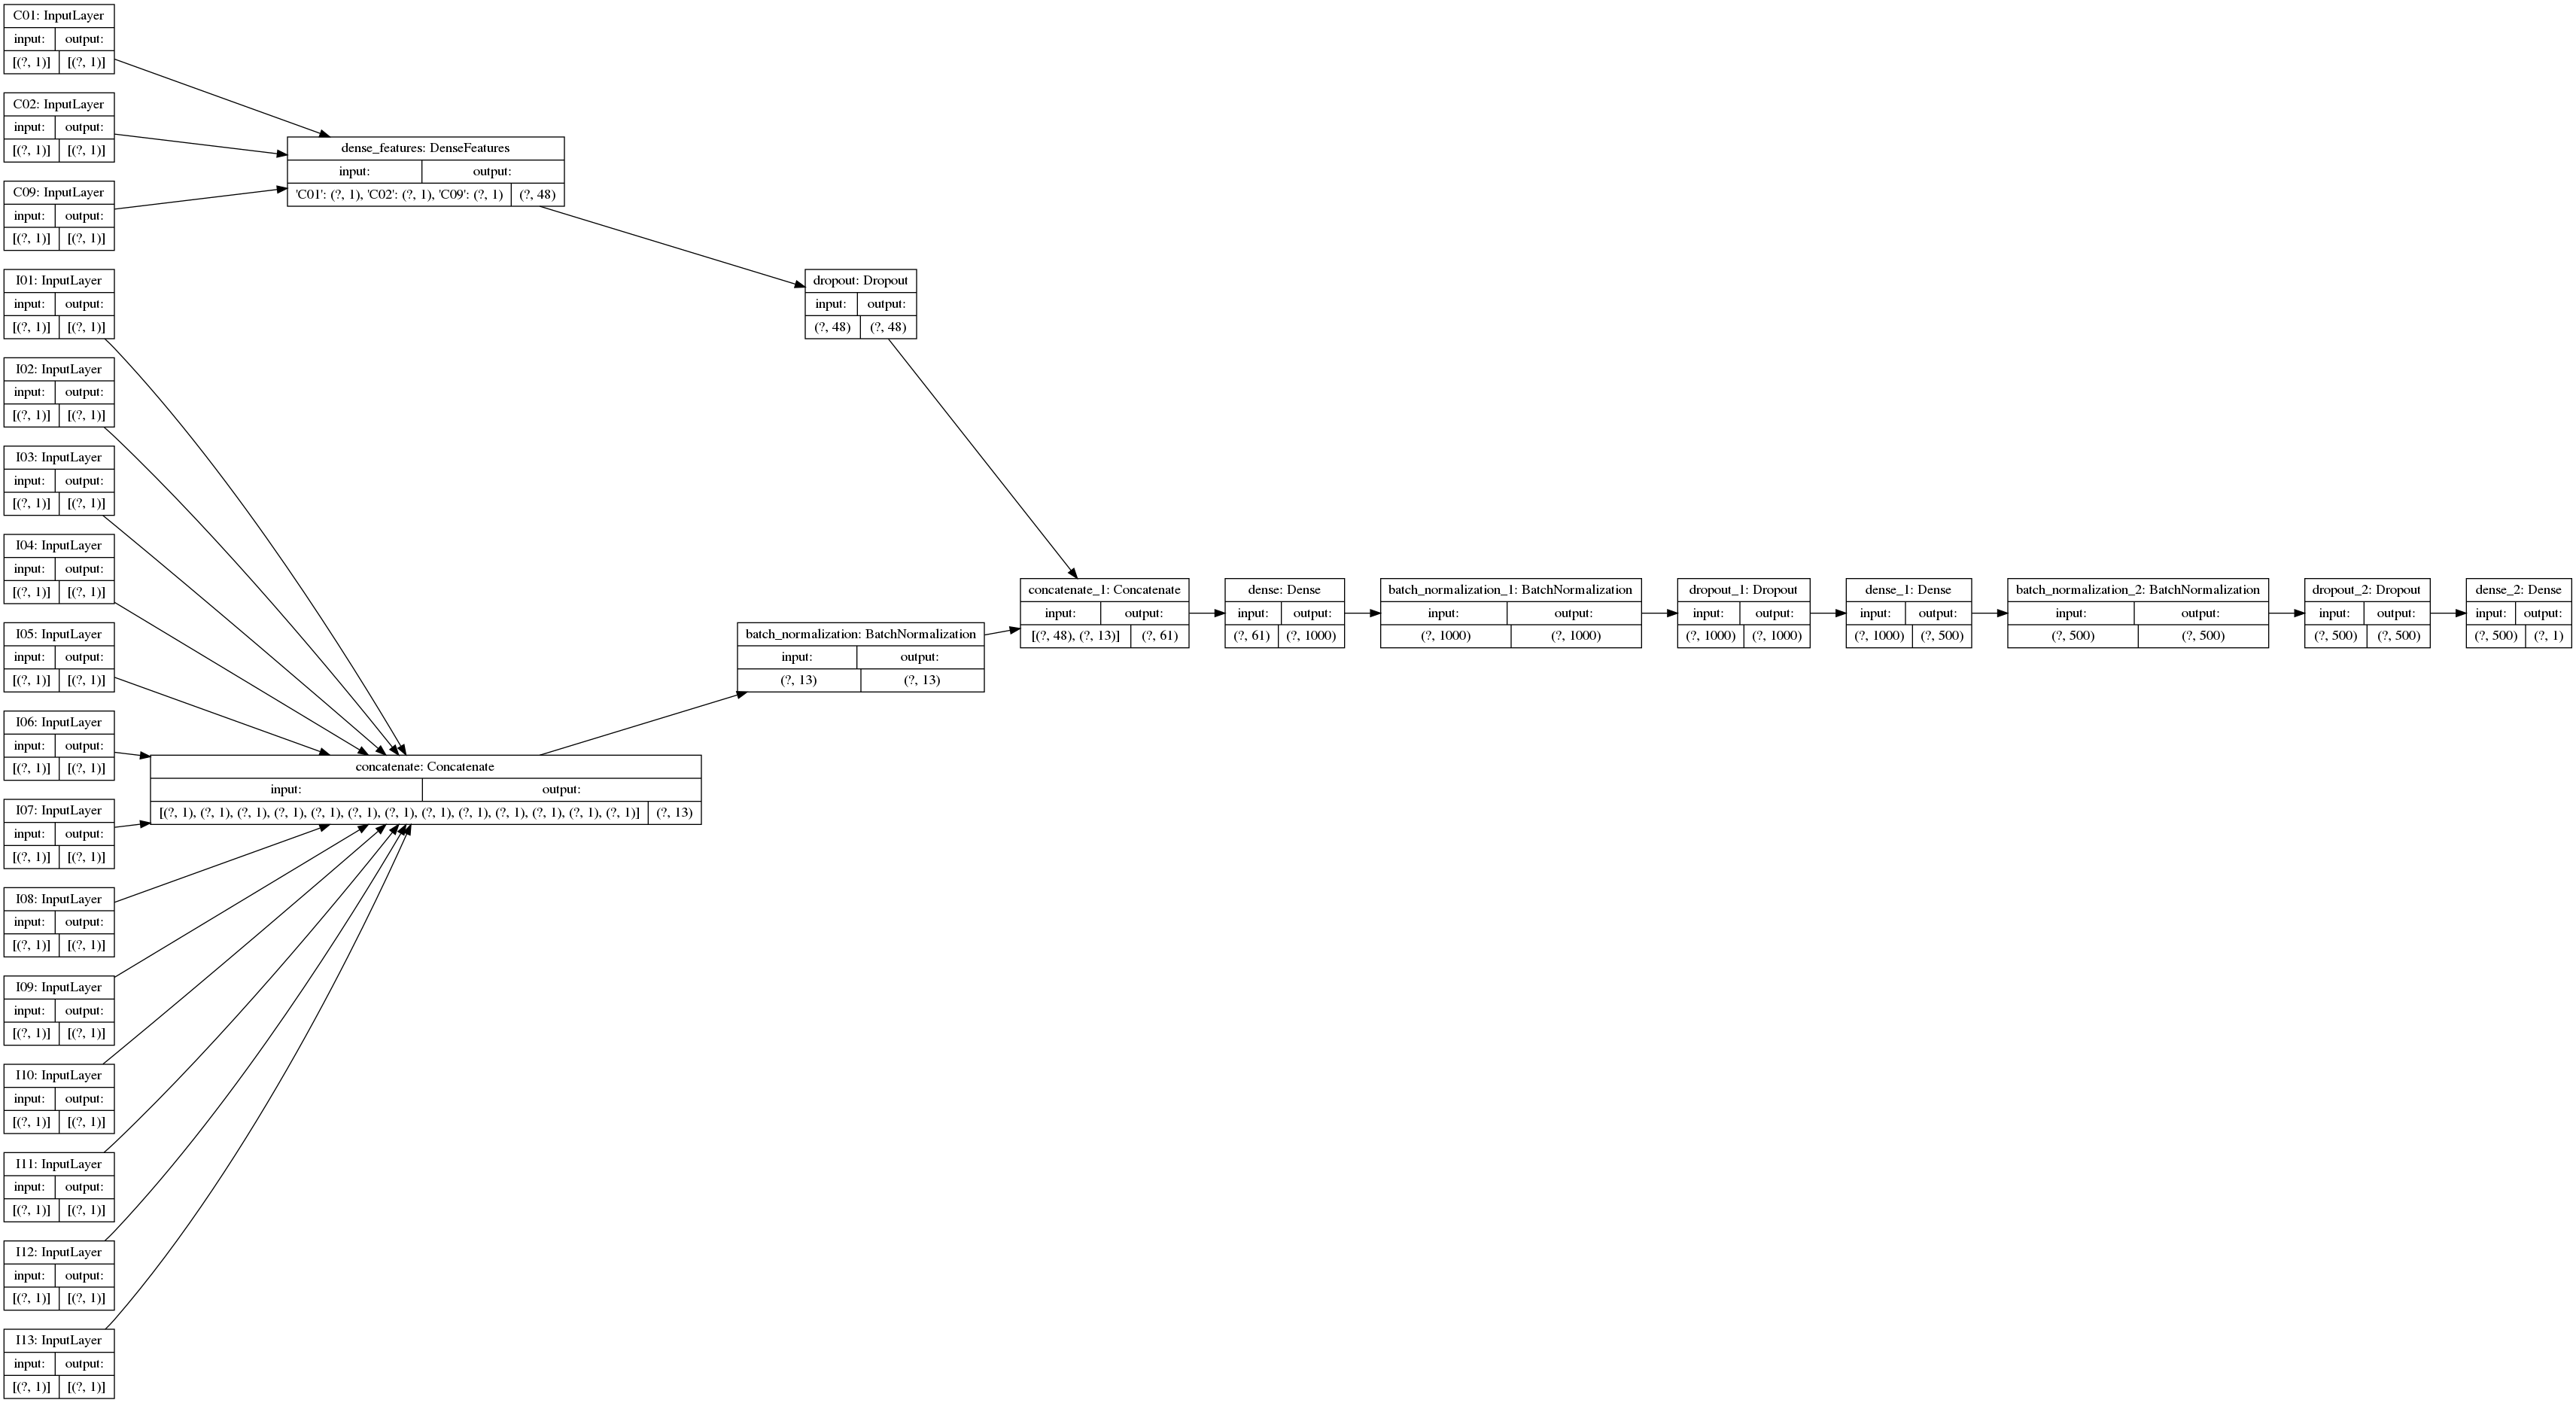

In [35]:
import pydot
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, rankdir='LR')

### TensorFlow: Training

In [36]:
from itertools import filterfalse
def print_param_counts(model):
    from functools import reduce
    mult = lambda x, y: x*y
    trainable_weights = model.trainable_weights
    check_name = lambda x: (
        x.name.split(':')[0].split('/')[-1] == "embedding_weights")

    trainable_embedding_weights = filter(check_name, trainable_weights)
    trainable_network_weights = filterfalse(check_name, trainable_weights)

    num_embedding_params = sum(
        [reduce(mult, x.shape) for x in trainable_embedding_weights]
    )
    num_network_params = sum(
        [reduce(mult, x.shape) for x in trainable_network_weights]
    )
    print("Embedding parameter count: {}".format(num_embedding_params))
    print("Non-embedding parameter count: {}".format(num_network_params))
    print("Trainable_network_weights: {}".format(trainable_network_weights))

In [37]:
logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %load_ext tensorboard
# %tensorboard --logdir {logs_base_dir}  --host 0.0.0.0

In [38]:
import datetime
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, update_freq='batch', profile_batch='100, 120', write_grads=True)

In [41]:
%%time
import datetime
import time 
start_time = time.time()

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

metrics = [tf.keras.metrics.AUC(curve="ROC", name="auroc")]
model.compile(optimizer, "binary_crossentropy", metrics=metrics)
print_param_counts(model)

history = model.fit(
    train_dataset_tf,
    validation_data=valid_dataset_tf,
    steps_per_epoch=STEPS,
    validation_steps=1000,
    epochs=10, callbacks=[tensorboard_callback]
)
# your code
elapsed_time = time.time() - start_time
print(elapsed_time)

Embedding parameter count: 74741232
Non-embedding parameter count: 566027
Trainable_network_weights: <itertools.filterfalse object at 0x7f670cbb7350>


/home/ronayak/ronaya/NVTabular/nvtabular/io.py:102: UserWarning: get_memory_info is not supported. Using total device memory from NVML.
  warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")


Epoch 1/10
   118/765008 [..............................] - ETA: 5:08:50 - loss: 0.3899 - auroc: 0.5255WARNING:tensorflow:From /home/ronayak/miniconda3/envs/0720/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
111031/765008 [===>..........................] - ETA: 4:31:21 - loss: 0.1281 - auroc: 0.7392

KeyboardInterrupt: 

In [41]:
max(history.history['val_auroc'])

0.7124722003936768

In [38]:
import pickle
metrics_cat3_smallvalid_freq2_10epoch_4=history.history
with open('metrics_cat3_smallvalid_freq2_10epoch_4' + '.pickle', 'wb') as output:
    pickle.dump(metrics_cat3_smallvalid_freq2_10epoch_4, output)

In [42]:
history.history

{'loss': [0.16782574355602264,
  0.13330531120300293,
  0.13124734163284302,
  0.13117514550685883,
  0.12779869139194489,
  0.1270855963230133,
  0.13087451457977295,
  0.12894630432128906,
  0.12807407975196838,
  0.12913081049919128],
 'auroc': [0.6163937449455261,
  0.6843644976615906,
  0.7000810503959656,
  0.7100031971931458,
  0.7138493657112122,
  0.7158167362213135,
  0.7192114591598511,
  0.7230878472328186,
  0.7198578119277954,
  0.7294971942901611],
 'val_loss': [0.13813214004039764,
  0.13804146647453308,
  0.13898004591464996,
  0.13396473228931427,
  0.13791395723819733,
  0.13491062819957733,
  0.13598604500293732,
  0.13629744946956635,
  0.13577955961227417,
  0.13692133128643036],
 'val_auroc': [0.6673916578292847,
  0.6852684020996094,
  0.6868550777435303,
  0.7065309882164001,
  0.6905856728553772,
  0.7108637094497681,
  0.707011878490448,
  0.6993446350097656,
  0.7124722003936768,
  0.6967121362686157]}

In [72]:
for layer in model.layers:
    if layer =='tensorflow.python.keras.feature_column.dense_features_v2.DenseFeatures object at 0x7ffa0610bd90':
        weights = layer.get_weights() # list of numpy arrays

In [176]:
model.layers

In [174]:
min(model.layers[27].get_weights()[0]), max(model.layers[27].get_weights()[0])

(array([-0.08870414], dtype=float32), array([0.09401658], dtype=float32))

In [153]:
model.get_weights()[2].shape

(61, 16)

In [161]:
model.get_weights()[2][60]

array([ 0.04631059, -0.05624681,  0.12547489,  0.00253199,  0.22462541,
       -0.30499092,  0.1348544 , -0.03489497,  0.07386065,  0.01192998,
        0.2584103 , -0.13702032,  0.00404516,  0.08187132, -0.01127156,
       -0.00593847], dtype=float32)

In [77]:
model.get_weights()[0].min(), model.get_weights()[0].max(),

(-1.0344049, 1.3708491)

In [37]:
# Generate generalization metrics
# score = model.evaluate(valid_dataset_tf)
# print(f'Test loss: {score[0]},  Test accuracy: {score[1]}')

25548/39063 [==================>...........] - ETA: 2:11 - loss: 0.1374 - auroc: 0.7171

/home/ronayak/ronaya/NVTabular/nvtabular/io.py:102: UserWarning: get_memory_info is not supported. Using total device memory from NVML.
  warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")


29052/39063 [=====================>........] - ETA: 1:37 - loss: 0.1374 - auroc: 0.7174

/home/ronayak/ronaya/NVTabular/nvtabular/io.py:102: UserWarning: get_memory_info is not supported. Using total device memory from NVML.
  warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")


39063/39063 [==============================] - 382s 10ms/step - loss: 0.1364 - auroc: 0.7185
Test loss: 0.1363680064678192,  Test accuracy: 0.7185462117195129


In [41]:
# with open("./nvt_stats/metrics_cat3_smallvalid_nofreq_10epoch.pickle", "rb") as f:
#     metrics_cat3_smallvalid_nofreq_10epoch = pickle.load(f)

In [41]:
np.log(298270301)

19.51351068368368

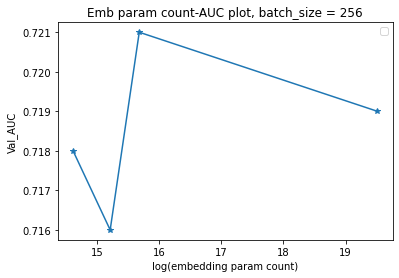

In [53]:
#plot
import matplotlib.pyplot as plt
import math
label=['nofreq', 'freq15', 'freq25', 'freq50']
x= np.log([298270301, 6469034, 4051980, 2231476])
y= [0.719, 0.721, 0.716, 0.718]
plt.xlabel("log(embedding param count)")
plt.ylabel("Val_AUC")
plt.title('Emb param count-AUC plot, batch_size = 256')
plt.legend(['nofreq', 'freq15', 'freq25', 'freq50'])
plt.plot(x,y, marker='*')